# Multi Modal Semantic Search - Data Enrichment

This notebook provides a walkthrough of a data enrichment of media assets using multi-modal LLMs. Raw images contain a lot of information and often these information are never leveraged during search. It is the purpose of this notebook to extract these metadata contained within the media assets such relevant descriptions, keywords and the tag. 

Often enrichment of media assets require a human to provide a description. Since the advent of Multi-modality of LLMs it is now possible to extract the relevant metadata from an asset in an automated fashion. This is not limited to media assets but can also be extended to graphic, illustrations, charts, graphs and other media formats. 

The following cell loads all the required libraries including instantiating a boto3 bedrock client

In [1]:
import os
import pandas as pd
import sagemaker
import boto3
import json
import pprint as pp
import os
import shutil
import csv
import time
import pprint
import base64
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

#get bedrock instances with boto3
bedrock = boto3.client('bedrock')
bedrock_client = boto3.client('bedrock-runtime')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Load the dataframe from previous notebook which includes real and fabricated images. 

In [2]:
# load the dataset from notebook 1 
%store -r df_images

In [3]:
df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,00a7655d4eabf186.jpg,./data/resized-images/00a7655d4eabf186.jpg,,,[],[],[]
1,19aa926f2f7d9782.jpg,./data/resized-images/19aa926f2f7d9782.jpg,,,[],[],[]
2,39209fa476d1430c.jpg,./data/resized-images/39209fa476d1430c.jpg,,,[],[],[]
3,1efc2db85591a04f.jpg,./data/resized-images/1efc2db85591a04f.jpg,,,[],[],[]
4,3c06d149c8027e71.jpg,./data/resized-images/3c06d149c8027e71.jpg,,,[],[],[]


## Enrichment from Raw Media assset using Bedrock 

For this step, we are going to leverage Claude 3 sonnet from Anthropic, which has multi-modal capabilities to extract various metadata from the raw media asset. 

Claude 3.5 Sonnet offers best-in-class vision capabilities compared to other leading models. It can accurately transcribe text from imperfect images—a core capability for retail, logistics, and financial services, where AI may glean more insights from an image, graphic, or illustration than from text alone. The latest Claude models demonstrate a strong aptitude for understanding a wide range of visual formats, including photos, charts, graphs and technical diagrams. With Claude, you can extract more insights from documents, process web UI and diverse product documentation, generate image catalog metadata, and more.



The following cell defines some helper functions to invoke Claude Sonnet 3.5 model as well as other handy utility functions to do convert images to base 64 as well as display images. 

In [4]:
# helper functions for generating metadata and creating some previews

modelid = 'anthropic.claude-3-sonnet-20240229-v1:0'


def image_to_base64(path):
    # Read reference image from file and encode as base64 strings.
    content_image = ""
    with open(path, "rb") as image_file:
        content_image = base64.b64encode(image_file.read()).decode('utf8')
    return content_image

def generate_metadata(bedrock_runtime, model_id, messages, max_tokens,top_p,temp):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]    

    return response_text

def bulk_extract_metadata(df_images):
    return df_images    

def display_image(path):
    im = Image.open(path)
    plt.imshow(im)
    plt.figure(figsize=(10, 10))
    plt.show()

### Enrichment of single media asset

Before running a batch operation accross all the assets, the following cells attempts to do enrichment for a single media asset for an initial test. For this purposes we are simply going to pick the first image in the dataframe. 

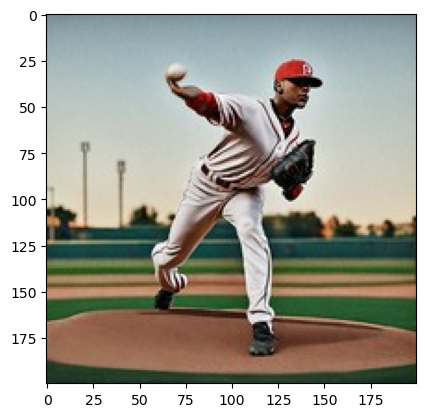

<Figure size 1000x1000 with 0 Axes>

In [5]:
# first enrich a single image 
# view the image we are trying to process - randomly pick an item
test_image_path = df_images.sample()["path"].values[0]
display_image(test_image_path)

The following cell defines Sonnet 3.5 prompt that we will be utilising to extract the required metadata. A basic COSTAR (context, objective, style, tone, audience, response) format is applied here. Note the use of XML tags which is an Anthropic specific prompt engineering best practice.

Since Sonnet 3.5 is has extensive vision capabilities we are are also utilising the model to extract various OCR texts that may be contained within the image. It is important to note that it is possible to create domain specific (e.g. travel, CPG) prompts to extract relevant metadata. Prompt engineering should be done to meet specific business needs and requirements and tested for accuracy before production use. 

Further information on [prompt engineering](https://aws.amazon.com/blogs/machine-learning/prompt-engineering-techniques-and-best-practices-learn-by-doing-with-anthropics-claude-3-on-amazon-bedrock/) can be found in this useful blog. 

In [6]:
# enrichment prompt 
# prepare the multimodal content message input for Claude 3 (separate json objects for image and text)
# define a prompt to get a title, description, tags, keywords from Claude 
# follow the costar principle (context, objective, style, tone, audience, response) 
prompt = """
You are a multimodal search engine metadata extractor. Your task is to carefully study the image, and extract tags, keywords, description, any text contained in the image, as well as forming a succinct title for the image.
Do not generated unwanted and uncessarily metadata, that will bloat the payload. Be detailed on various aspects of the image such as background, foreground and subject of the image.
If media contains no OCR texts then simply generate an empty string for it. 
Make necessary determination on the key category/theme of the image and generate keywords as appropriate. 

All metadata extracted is required to be professional for official use. Refrain from using informal language. 

The intended audience are various business users who will attempt to search based on keywords or describing in natural language what they are looking for. For this purpose generate a description the image and include finer details that can be used for search purposes alongisde keywords and tags. 

Output the metadata as well formed JSON as defined in the <example> XML tags. Do not include XML tags in the output.  

<example>
    {
        "title":"baseball player swinging bat",
        "description":"baseball player wearing team jersey swinging bat to score a home run. In the background there are cheering fans who are joyous and having a wonderful time. Stadium atmosphere seems electric.",
        "keywords":"baseball, sports, homerun, bat, player, jersey",
        "tags":"sports, stadium, baseball, crowd"
        "ocr_texts":"new york mets, mets, new york, richardson, 66"
    }
<example>
"""

def prepare_mm_input(path):
    # Read reference image from file and encode as base64 strings.
    content_image = image_to_base64(path)
    message_mm = [
        { "role": "user",
          "content": [
          {"type": "image","source": { "type": "base64","media_type":"image/jpeg","data": content_image}},
          {"type": "text","text": prompt}
          ]
        }
    ]
    return message_mm

The following cells invokes the Sonnet model and prints the output.

In [7]:
# test the single image 
# note: the enriched output quality will vary depending on quality of image (ie. blurry text) 
message_mm = prepare_mm_input(test_image_path)
response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)

In [8]:
pprint.pp(response)

('{\n'
 '    "title": "Baseball Pitcher in Mid-Delivery",\n'
 '    "description": "The image depicts a baseball pitcher in the midst of '
 'delivering a pitch. The player is wearing a red cap and a white jersey with '
 'pinstripes, suggesting they are part of a professional baseball team. The '
 'background shows a baseball field with a pitching mound in the foreground '
 'and a stadium in the distance, indicating an official game setting.",\n'
 '    "keywords": "baseball, pitcher, sports, athlete, delivery, pitching, '
 'mound, stadium",\n'
 '    "tags": "baseball, sports, athlete, pitching, stadium, game",\n'
 '    "ocr_texts": ""\n'
 '}')


### Bulk metadata extraction using Claude Sonnet 

Now that we can verify the enrichment for one image, we can apply the same logic accross all the media assets in the dataframe. Ideally, this process should be written and run in an enrichment pipeline but for simplicy we have opted to simply run it accross multiple threads and create a new dataframe with all LLM extracted keywords, description, title, tags, and OCR texts. 

Note: This process may take several minutes 


In [9]:
from tqdm import tqdm
import tqdm.notebook as tq

# called by each thread
def get_metadata(item):
    message_mm = prepare_mm_input(item.iloc[1])
    response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)
    json_response = json.loads(response)
    response = {
        "image_id":item.iloc[0],
        "path":item.iloc[1],
        "title":json_response["title"],
        "description":json_response["description"],
        "keywords":json_response["keywords"],
        "tags":json_response["tags"]
    }
    return response

metadata_list = [] 
for idx, record in tq.tqdm(df_images.iterrows(), total=len(df_images)):
    response = get_metadata(record)
    metadata_list.append(response)

  0%|          | 0/107 [00:00<?, ?it/s]

In [12]:
df_metadata = pd.DataFrame(metadata_list)
df_metadata.head()

,image_id,path,title,description,keywords,tags
0,00a7655d4eabf186.jpg,./data/resized-images/00a7655d4eabf186.jpg,Baseball player batting during a game,The image depicts a baseball player in a batti...,"baseball, sports, batting, player, jersey, sta...","baseball, sports, athlete, action, competition"
1,19aa926f2f7d9782.jpg,./data/resized-images/19aa926f2f7d9782.jpg,Baseball Player Batting During a Game,The image depicts a professional baseball play...,"baseball, sports, athlete, batting, swing, sta...","baseball, sports, athlete, batting, stadium, g..."
2,39209fa476d1430c.jpg,./data/resized-images/39209fa476d1430c.jpg,Baseball Players Gathered on Field,The image depicts a group of baseball players ...,"baseball, players, team, field, uniforms, bats...","sports, baseball, athletes, coaching, team gat..."
3,1efc2db85591a04f.jpg,./data/resized-images/1efc2db85591a04f.jpg,Baseball batter at home plate,The image depicts a baseball game in progress....,"baseball, batter, swing, pitch, catcher, field...","baseball, sports, game, athlete, competition"
4,3c06d149c8027e71.jpg,./data/resized-images/3c06d149c8027e71.jpg,Youth Baseball Player Batting,The image depicts a young baseball player in a...,"baseball, youth sports, batting, swing, athlet...","sports, baseball, youth, athlete, batting"


## Generate Vector Embeddings

A standard approach to conducting semantic and similarity search is to leverage vector embeddings created using an LLM capable of generating embeddings. 

Let's start with the basics: what is an embedding? An embedding is a numerical representation of content in a form that machines can process and understand. The essence of the process is to convert an object, such as an image or text, into a vector that encapsulates its semantic content while discarding irrelevant details as much as possible. An embedding takes a piece of content, like a word, sentence, or image, and maps it into a multi-dimensional vector space. The distance between two embeddings indicates the semantic similarity between the corresponding concepts.

Consider the terms 'coffee' and 'tea'. In a hypothetical vocabulary space, these two could be transformed into numerical vectors. If we visualize this in a 3-dimensional vector space, 'coffee' might be represented as [1.2, -0.9, 0.3] and 'tea' as [1.0, -0.8, 0.5]. Such numerical vectors carry semantic information, indicating that 'coffee' and 'tea' are conceptually similar to each other due to their association with hot beverages and would likely be positioned closer together in the vector space than either would be to unrelated concepts like 'astronomy' or 'philosophy'.

For the purpose of this exercise we are going to utilise Titan Multimodal Embeddings G1 model. The Titan Multimodal Embeddings G1 model translates text inputs (words, phrases or possibly large units of text) as well as images into numerical representations (known as embeddings) that contain the semantic meaning of the text and image. While this model will not generate text as an output, it is useful for applications like personalization and search.

In later notebooks, we will be storing these embeddings in a vector database to conduct search operations. 

The following cell defines a function to generate the embeddings by invoking titan-embed-image-v1 model. Since the input payload may also be an image asset we are required to create base64 encoding of the image before carrying out the model invocation. Note the output vector dimension of 1024 default but smaller embeddings space can be created if needed.  

In [13]:
# helper function to generate embeddings

# Select Amazon titan-embed-image-v1 as Embedding model for multimodal indexing
multimodal_embed_model = f'amazon.titan-embed-image-v1'

def generate_embeddings(
    imgpath: str = None,  # maximum 2048 x 2048 pixels
    text: str = None,  # optional text to embed
    dimension: int = 1024,  # 1,024 (default), 384, 256
    model_id: str = multimodal_embed_model
):
    payload_body = {}
    embedding_config = {
        "embeddingConfig": { 
             "outputEmbeddingLength": dimension
         }
    }

    # titan can generate embeddings for txt and img 
    if imgpath:
        with open(imgpath, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')
            payload_body["inputImage"] = input_image
    if text:
        payload_body["inputText"] = text

    response = bedrock_client.invoke_model(
        body=json.dumps({**payload_body, **embedding_config}),
        modelId=model_id,
        accept="application/json",
        contentType="application/json"
    )

    return json.loads(response.get("body").read())


Following cell generates embedding for the same test image we picked for enrichment purpose. 

In [14]:
# lets generate the embeddings for the same test image

embedding = generate_embeddings(test_image_path)["embedding"]

Now that we can generate embeddings for a single image, we are required to batch process the dataframe and generate embeddings for all images in the dataframe. A simple iterator is used to loop over the dataset and adding the record to the dataframe. 

In [15]:
# generate the embeddings for all the images in the dataset 
multimodal_embeddings_img = []

for idx, image in df_metadata.iterrows():
    embedding = generate_embeddings(imgpath=image['path'])["embedding"]
    multimodal_embeddings_img.append(embedding)

df_metadata = df_metadata.assign(embeddings=multimodal_embeddings_img)


Quick preview of the dataframe which should now contain all enriched data extracted using Claude Sonnet as well as the emebddings generated using Titan. 

In [16]:
# lets preview the dataset which should now contain a fully enriched dataset
df_metadata.head()

,image_id,path,title,description,keywords,tags,embeddings
0,00a7655d4eabf186.jpg,./data/resized-images/00a7655d4eabf186.jpg,Baseball player batting during a game,The image depicts a baseball player in a batti...,"baseball, sports, batting, player, jersey, sta...","baseball, sports, athlete, action, competition","[0.041014045, 0.021385895, -0.02275303, 0.0187..."
1,19aa926f2f7d9782.jpg,./data/resized-images/19aa926f2f7d9782.jpg,Baseball Player Batting During a Game,The image depicts a professional baseball play...,"baseball, sports, athlete, batting, swing, sta...","baseball, sports, athlete, batting, stadium, g...","[0.03466529, 0.02793032, -0.029118843, -0.0156..."
2,39209fa476d1430c.jpg,./data/resized-images/39209fa476d1430c.jpg,Baseball Players Gathered on Field,The image depicts a group of baseball players ...,"baseball, players, team, field, uniforms, bats...","sports, baseball, athletes, coaching, team gat...","[0.031110628, 0.030195609, -0.060391217, -0.01..."
3,1efc2db85591a04f.jpg,./data/resized-images/1efc2db85591a04f.jpg,Baseball batter at home plate,The image depicts a baseball game in progress....,"baseball, batter, swing, pitch, catcher, field...","baseball, sports, game, athlete, competition","[0.047018528, 0.025594763, -0.030524123, 0.023..."
4,3c06d149c8027e71.jpg,./data/resized-images/3c06d149c8027e71.jpg,Youth Baseball Player Batting,The image depicts a young baseball player in a...,"baseball, youth sports, batting, swing, athlet...","sports, baseball, youth, athlete, batting","[0.011220759, 0.06612398, -0.048392408, -0.019..."


The following cell simply loads a custom helpers module from the ./src/helpers directory to the system path. This module contains various helper functions that will be used throughout the labs. For now we only require the similary heat map function to create a heatmap of all the embeddings contained in the dataframe. 

In [21]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [22]:
#adding our utils library to sys path
import sys
sys.path.append("./src/helpers/")
from utils import *

The heatmap below should indicate a clear pattern since we have overloaded the dataset with some fabricated images that are similar in nature. This is done for illustrative purposes only. 

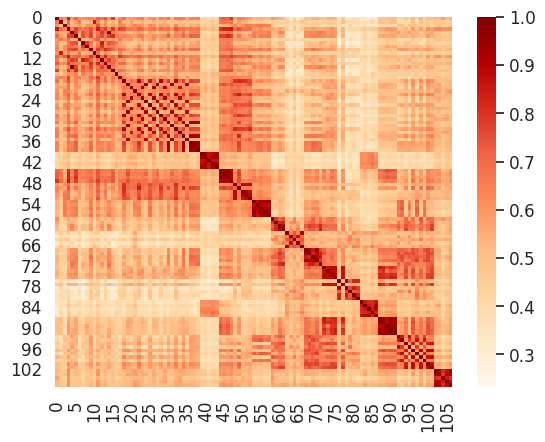

In [23]:
# generate a similarity heatmap of the images in the dataset based on the embeddings 
# the heatmap should theoretically indicate distinct patches for baseball, savannah, lion due to addition of fabiracated images
plot_similarity_heatmap(multimodal_embeddings_img, multimodal_embeddings_img)

Following cells saves the enriched dataframe as well as writing the dataframe as a CSV file to disc. 

In [24]:
# save for use in next notebook 
%store df_metadata

Stored 'df_metadata' (DataFrame)


In [25]:
# save as CSV for later use 
df_metadata.to_csv('./data/enriched_dataset.csv', index=False)